In [21]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
import astropy.units as u 
from astropy.coordinates import SkyCoord
from astropy.io import ascii

import astroquery
from astroquery.mast import Catalogs
from astroquery.mast import Observations
from astroquery.mast import Tesscut

import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

import glob, re

from tools import has_data, find_in_tess

% matplotlib inline

import matplotlib as mpl
from matplotlib import rc

mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
fname = '../data/lmxb_table.csv'
xrbs = Table.read(fname,delimiter='|')
xrbs.rename_column('name','Name')
# bhs.rename_column('RA (h:m:s)','RA')
# for key in bhs.keys():
#     if 'DEC' in key: 
#         bhs.rename_column(key,'Dec')

In [3]:
xrbs.keys()

['Name',
 'ra',
 'dec',
 'lim_mag1',
 'mag1',
 'type1',
 'orbital_period',
 'orbital_period_flag',
 'lim_lx_lopt',
 'lx_lopt',
 'period2',
 'period2_flag',
 'period3',
 'period3_flag',
 'period4',
 'eclipse',
 'lim_mass_ratio',
 'mass_ratio',
 'lim_inclination',
 'inclination',
 'inclination_flag',
 'inclination_error',
 'm1',
 'm1_flag',
 'm1_error',
 'lim_m2',
 'm2',
 'm2_flag',
 'm2_error',
 'class',
 'col30']

In [17]:
in_tess = find_in_tess(xrbs)

/anaconda2/envs/py36/lib/python3.6/site-packages/astroquery/utils/commons.py:171: UserWarning: Coordinate string is being interpreted as an ICRS coordinate provided in degrees.
  warnings.warn("Coordinate string is being interpreted as an "


NGC 104-X5
NGC 104-X7
NGC 104-W37
LMC X-2
J1306-7027
GR Mus
GU Mus
UY Vol
KZ TrA
BW Cir
V395 Car
QU TrA
1323-6152
LU TrA
J1910-5959#1
V381 Nor
J1538-5542
0918-5459
V801 Ara
QX Nor
J1650-4957
1624-4904
J1227-4853
V821 Ara
IL Lup
MM Vel
V926 Sco
1705-4402
0512-4006
V1033 Sco
J0055-3738
1746-3702
V4580 Sgr
V1101 Sco
J1748-3607
J0556-3310
BW Ant
['NGC 104-X5', 'NGC 104-X7', 'NGC 104-W37', 'LMC X-2', 'J1306-7027', 'GR Mus', 'GU Mus', 'UY Vol', 'KZ TrA', 'BW Cir', 'V395 Car', 'QU TrA', '1323-6152', 'LU TrA', 'J1910-5959#1', 'V381 Nor', 'J1538-5542', '0918-5459', 'V801 Ara', 'QX Nor', 'J1650-4957', '1624-4904', 'J1227-4853', 'V821 Ara', 'IL Lup', 'MM Vel', 'V926 Sco', '1705-4402', '0512-4006', 'V1033 Sco', 'J0055-3738', '1746-3702', 'V4580 Sgr', 'V1101 Sco', 'J1748-3607', 'J0556-3310', 'BW Ant']


In [19]:
indices = has_data(in_tess)


J0055-3738 13.795 -37.648

LMC X-2 80.118 -71.959

NGC 104-W37 6.021 -72.081

NGC 104-X5 6.004 -72.081

NGC 104-X7 6.015 -72.081

UY Vol 117.140 -67.752



In [20]:
in_tess[indices]

Name,ra,dec,lim_mag1,mag1,type1,orbital_period,orbital_period_flag,lim_lx_lopt,lx_lopt,period2,period2_flag,period3,period3_flag,period4,eclipse,lim_mass_ratio,mass_ratio,lim_inclination,inclination,inclination_flag,inclination_error,m1,m1_flag,m1_error,lim_m2,m2,m2_flag,m2_error,class,col30
str12,str10,str9,str4,float64,str2,float64,str1,str4,float64,float64,str1,float64,str1,int64,str2,str4,float64,str4,float64,str1,float64,float64,str1,float64,str4,float64,str1,float64,str22,int64
J0055-3738,00 55 10.9,-37 38 54,--,--,SS,0.225,:,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,SUPERSOFT SOURCE,--
LMC X-2,05 20 28.3,-71 57 32,--,16.7,EG,0.32,:,--,400.0,12.543,:,--,--,--,1,--,--,--,--,--,--,--,--,--,--,--,--,--,LMXRB,--
NGC 104-W37,00 24 05.0,-72 04 51,--,--,QN,0.1286,:,--,--,--,--,--,--,--,1?,--,--,--,--,--,--,--,--,--,--,--,--,--,LMXRB,--
NGC 104-X5,00 24 00.9,-72 04 53,--,21.7,XT,0.3611,--,--,--,--,--,--,--,--,1,--,--,--,--,--,--,--,--,--,--,--,--,--,LMXRB,--
NGC 104-X7,00 24 03.5,-72 04 52,--,--,XT,0.23,:,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,LMXRB,--
UY Vol,07 48 33.7,-67 45 08,--,21.7,XT,0.159338,--,--,--,--,--,0.00181,--,--,1,--,--,--,--,--,--,1.27,--,--,--,--,--,--,LMXRB BURSTER,--


### Sweet! LMC X-2 has been observed.

In [7]:
fname_data = '../data/tess-s0001-4-2_80.118_-71.959_10x15_astrocut.fits'

In [8]:
tpf = TessTargetPixelFile.from_fits(fname_data)

/anaconda2/envs/py36/lib/python3.6/site-packages/lightkurve/targetpixelfile.py:247: LightkurveWarning: `TargetPixelFile.from_fits()` is deprecated and will be removed soon, please use `lightkurve.open()` instead.
  LightkurveWarning)


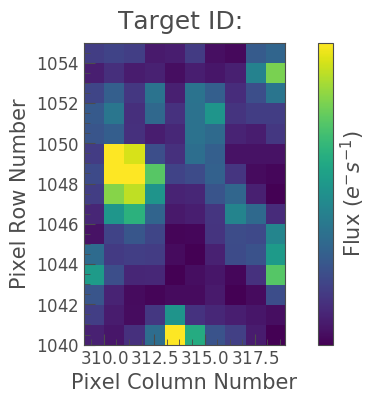

In [9]:
tpf.plot(frame=1,scale='log')


In [10]:
npix = 2.5
cen = [0.5,-3]

newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')
xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))
rr = np.sqrt((xx-newmask.shape[0]/2-cen[0])**2 + (yy-newmask.shape[1]/2-cen[1])**2)

newmask[(rr>npix).T] = False
newmask[(rr<npix).T] = True


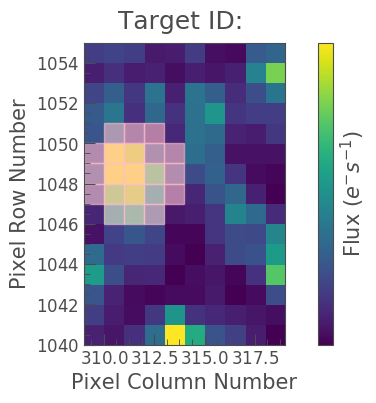

In [11]:
tpf.plot(frame=1,scale='log',aperture_mask=newmask)


In [12]:
lc = tpf.to_lightcurve(aperture_mask=newmask)
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


(1328, 1334)

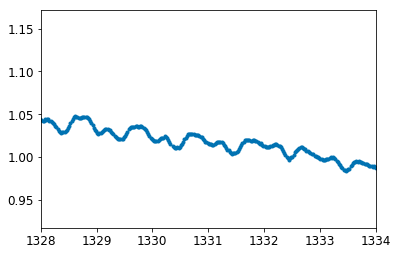

In [13]:
plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.')
# plt.ylim(0.9,1.1)
plt.xlim(1328,1334)